In [20]:
# Cell 1: Import required libraries
import cudf
import numpy as np
from cuml.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from cuml.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.combine import SMOTEENN
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
processed_train_path = '/root/autodl-tmp/projects/SL_NSL/dataset/processed/bin/KDDTrain_processed.csv'
processed_test_path = '/root/autodl-tmp/projects/SL_NSL/dataset/processed/bin/KDDTest_processed.csv'

In [21]:
# Cell 2: Load and Preprocess Training Data
print("Loading processed training data...")
df_train = cudf.read_csv(processed_train_path)

# Select features and labels
X = df_train.drop(columns=['binary_label'])
y_binary = df_train['binary_label']

# Convert CUDA DataFrame to pandas for resampling
X_pd = X.to_pandas()
y_pd = y_binary.to_pandas()

print("Feature matrix shape:", X.shape)
print("Original label distribution:")
print(np.bincount(y_pd))

Loading processed training data...
Feature matrix shape: (125973, 108)
Original label distribution:
[67343 58630]


In [22]:
# Cell 3: Apply Advanced Resampling Strategy
print("Original class distribution:")
print(pd.Series(y_pd).value_counts())

# Use SMOTEENN to combine oversampling and cleaning
sampler = SMOTEENN(
    sampling_strategy={1: int(len(y_pd[y_pd==0])*0.95)},
    random_state=42
)
X_resampled, y_resampled = sampler.fit_resample(X_pd, y_pd)

print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts())

Original class distribution:
0    67343
1    58630
Name: binary_label, dtype: int64

Resampled class distribution:
0    66605
1    63246
Name: binary_label, dtype: int64


In [23]:
# Cell 4: Define and Configure XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.01,  # Reduce learning rate
    max_depth=6,     # Decrease tree depth
    min_child_weight=5,  # Increase to reduce overfitting
    subsample=0.7,   # Reduce sample usage
    colsample_bytree=0.7,  # Reduce feature usage
    reg_alpha=0.5,   # L1 regularization
    reg_lambda=2,    # L2 regularization
    scale_pos_weight=1.15,  # Class weight
    random_state=42,
    tree_method='hist',
    device='cuda'
)

# Setup stratified cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [24]:
# Cell 5: Perform Cross-Validation
# Initialize storage for results
cv_scores = []
feature_importance_list = []
optimal_thresholds = []

# Execute cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_resampled, y_resampled)):
    print(f"\nFold {fold+1}/{n_splits}")
    
    # Split data
    X_train_fold = X_resampled.iloc[train_idx]
    y_train_fold = y_resampled[train_idx]
    X_val_fold = X_resampled.iloc[val_idx]
    y_val_fold = y_resampled[val_idx]
    
    # Train model
    xgb_model.fit(
        X_train_fold, 
        y_train_fold,
        eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)]
    )
    
    # Find optimal threshold
    y_scores = xgb_model.predict_proba(X_val_fold)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_scores)
    f1_scores = 2*(precisions*recalls)/(precisions+recalls)
    optimal_idx = np.argmax(f1_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)
    
    # Predict using optimal threshold
    y_pred = (y_scores > optimal_threshold).astype(int)
    acc_score = accuracy_score(y_val_fold, y_pred)
    cv_scores.append(acc_score)
    
    # Store feature importance
    feature_importance_list.append(xgb_model.feature_importances_)
    
    print(f"Fold {fold+1} Accuracy: {acc_score:.4f} (threshold: {optimal_threshold:.4f})")
    print("\nDetailed metrics for this fold:")
    print(classification_report(y_val_fold, y_pred))

# Print cross-validation results
print("\nCross-validation results:")
print(f"Mean accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
print(f"Mean optimal threshold: {np.mean(optimal_thresholds):.4f}")


Fold 1/5
[0]	validation_0-logloss:0.68583	validation_1-logloss:0.68581
[1]	validation_0-logloss:0.67626	validation_1-logloss:0.67625
[2]	validation_0-logloss:0.66703	validation_1-logloss:0.66701
[3]	validation_0-logloss:0.65806	validation_1-logloss:0.65803
[4]	validation_0-logloss:0.64938	validation_1-logloss:0.64934
[5]	validation_0-logloss:0.64092	validation_1-logloss:0.64088
[6]	validation_0-logloss:0.63222	validation_1-logloss:0.63218
[7]	validation_0-logloss:0.62374	validation_1-logloss:0.62370
[8]	validation_0-logloss:0.61540	validation_1-logloss:0.61537
[9]	validation_0-logloss:0.60723	validation_1-logloss:0.60719
[10]	validation_0-logloss:0.59944	validation_1-logloss:0.59941
[11]	validation_0-logloss:0.59151	validation_1-logloss:0.59148
[12]	validation_0-logloss:0.58377	validation_1-logloss:0.58374
[13]	validation_0-logloss:0.57620	validation_1-logloss:0.57615
[14]	validation_0-logloss:0.56871	validation_1-logloss:0.56867
[15]	validation_0-logloss:0.56136	validation_1-logloss:

In [25]:
# Cell 6: Analyze Feature Importance
mean_importance = np.mean(feature_importance_list, axis=0)
feature_importance = pd.DataFrame({
    'feature': X_resampled.columns,
    'importance': mean_importance
})
print("\nTop 10 most important features (averaged across folds):")
display(feature_importance.sort_values('importance', ascending=False).head(10))


Top 10 most important features (averaged across folds):


,feature,importance
96,src_bytes,0.221126
0,flag_SF,0.163029
16,service_ecr_i,0.106258
101,dst_bytes,0.092321
14,protocol_type_icmp,0.073322
13,diff_srv_rate,0.053295
5,service_http,0.040618
4,count,0.021081
61,protocol_type_tcp,0.017888
6,service_private,0.017844


In [26]:
# Cell 7: Train Final Model
print("\nTraining final model on full resampled dataset...")
xgb_model.fit(
    X_resampled, 
    y_resampled,
    eval_set=[(X_resampled, y_resampled)]
)

# Use mean optimal threshold from cross-validation
final_threshold = np.mean(optimal_thresholds)
print(f"Using optimal threshold: {final_threshold:.4f}")


Training final model on full resampled dataset...
[0]	validation_0-logloss:0.68581
[1]	validation_0-logloss:0.67627
[2]	validation_0-logloss:0.66694
[3]	validation_0-logloss:0.65795
[4]	validation_0-logloss:0.64925
[5]	validation_0-logloss:0.64078
[6]	validation_0-logloss:0.63209
[7]	validation_0-logloss:0.62361
[8]	validation_0-logloss:0.61526
[9]	validation_0-logloss:0.60709
[10]	validation_0-logloss:0.59931
[11]	validation_0-logloss:0.59138
[12]	validation_0-logloss:0.58364
[13]	validation_0-logloss:0.57606
[14]	validation_0-logloss:0.56857
[15]	validation_0-logloss:0.56120
[16]	validation_0-logloss:0.55411
[17]	validation_0-logloss:0.54705
[18]	validation_0-logloss:0.54031
[19]	validation_0-logloss:0.53341
[20]	validation_0-logloss:0.52679
[21]	validation_0-logloss:0.52009
[22]	validation_0-logloss:0.51354
[23]	validation_0-logloss:0.50712
[24]	validation_0-logloss:0.50111
[25]	validation_0-logloss:0.49497
[26]	validation_0-logloss:0.48882
[27]	validation_0-logloss:0.48278
[28]	va

In [27]:
# Cell 8: Evaluate on External Test Set
print("\nEvaluating on external test set...")
df_test = cudf.read_csv(processed_test_path)
X_external_test = df_test.drop(columns=['binary_label'])
y_external_test = df_test['binary_label']

# Convert to pandas for prediction
X_external_test_pd = X_external_test.to_pandas()
y_external_scores = xgb_model.predict_proba(X_external_test_pd)[:, 1]
y_external_pred = (y_external_scores > final_threshold).astype(int)
y_external_test_np = y_external_test.to_numpy()

# Calculate metrics
accuracy_external = accuracy_score(y_external_test_np, y_external_pred)
conf_matrix_external = confusion_matrix(y_external_test_np, y_external_pred)
class_report_external = classification_report(y_external_test_np, y_external_pred)

print(f"External Test Set Accuracy: {accuracy_external:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix_external)
print("\nClassification Report:")
print(class_report_external)


Evaluating on external test set...
External Test Set Accuracy: 0.89

Confusion Matrix:
[[ 7591  2120]
 [  424 12409]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      9711
           1       0.85      0.97      0.91     12833

    accuracy                           0.89     22544
   macro avg       0.90      0.87      0.88     22544
weighted avg       0.89      0.89      0.89     22544



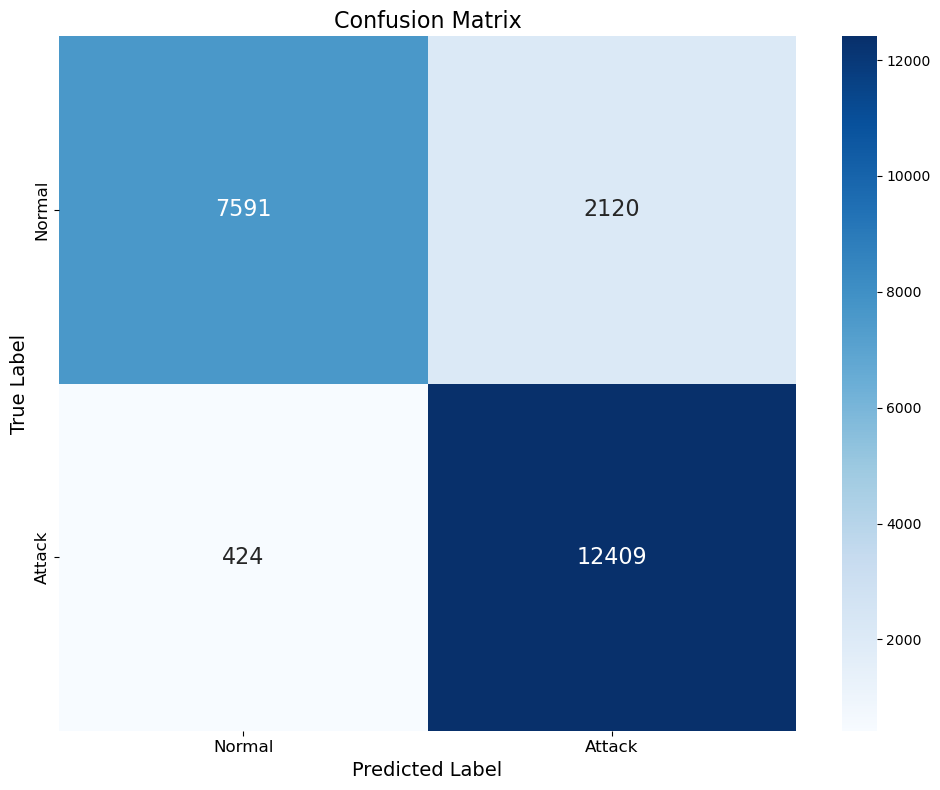

In [28]:
plt.figure(figsize=(10, 8))  # Increased figure size for better visibility

# Convert CuPy array to NumPy
if hasattr(conf_matrix_external, 'get'):
    conf_matrix_np = conf_matrix_external.get()
else:
    conf_matrix_np = conf_matrix_external

# Define class names for binary classification (Normal and Attack)
class_names = ['Normal', 'Attack']

# Increase annotation font size with annot_kws
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 16})  # Increase the size of numbers in cells

# Increase font size for axes labels
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)  # Larger title font

# Increase tick labels font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)  # Higher DPI for better quality
plt.show()